# Projeto - Airline AI Assistant

Vamos criar um assistente de suporte ao cliente de IA para uma companhia aérea

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

c:\Users\eders\anaconda3\envs\llm_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Inicialização

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key existe e começa com {openai_api_key[:8]}")
else:
    print("OpenAI API Key não encontrada.")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key existe e começa com sk-proj-


In [3]:
system_message = "Você é um assistente útil para uma companhia aérea chamada FlightAI."
system_message += "Vocês deve responder a todas as perguntas em portugês do Brasil."
system_message += "Dê respostas curtas e educadas, não mais do que 1 frase. "
system_message += "Seja sempre preciso. Se você não sabe a resposta, diga."

## Tools

"Tools" são um recurso poderoso fornecido pelos LLMs de ponta.

Com "tools", você pode escrever uma função e fazer com que o LLM chame essa função como parte de sua resposta.


In [29]:
# Vamos começar criando uma função simples de exemplo

ticket_prices = {"londres": "R$ 799", "paris": "R$ 899", "tokio": "R$ 1400", "berlin": "R$ 499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [30]:
# Teste da função
get_ticket_price("Londres")

Tool get_ticket_price called for Londres


'R$ 799'

In [25]:
# Há uma estrutura de dicionário específica que é necessária para descrever nossa função:

price_function = {
    "name": "get_ticket_price",
    "description": "Obtenha o preço de uma passagem de volta para a cidade de destino. Chame isso sempre que precisar saber o preço da passagem, por exemplo, quando um cliente perguntar 'Quanto custa uma passagem para esta cidade'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "A cidade para onde o cliente deseja viajar",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [26]:
# Em seguida incluimos em uma lista:

tools = [{"type": "function", "function": price_function}]

## Fazendo com que o OpenAI use nossa "tool"

temos que utilizar o parametro 'tools' no create

In [8]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [9]:
# Também é preciso escrever a função handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [10]:
# Testando nosso chat
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# Experimentando o multi-modal!!

Podemos usar o DALL-E-3, o modelo de geração de imagens por trás do GPT-4o, para criar algumas imagens

Vamos colocar isso em uma função chamada artist.



In [11]:
# Testando nossa função de criação de imagens
# Alguns imports para manipulação de imagens

import base64
from io import BytesIO
from PIL import Image

In [12]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"Uma imagem representando férias em {city}, mostrando pontos turísticos e tudo o que há de único em {city}, em um estilo realista e vibrante",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

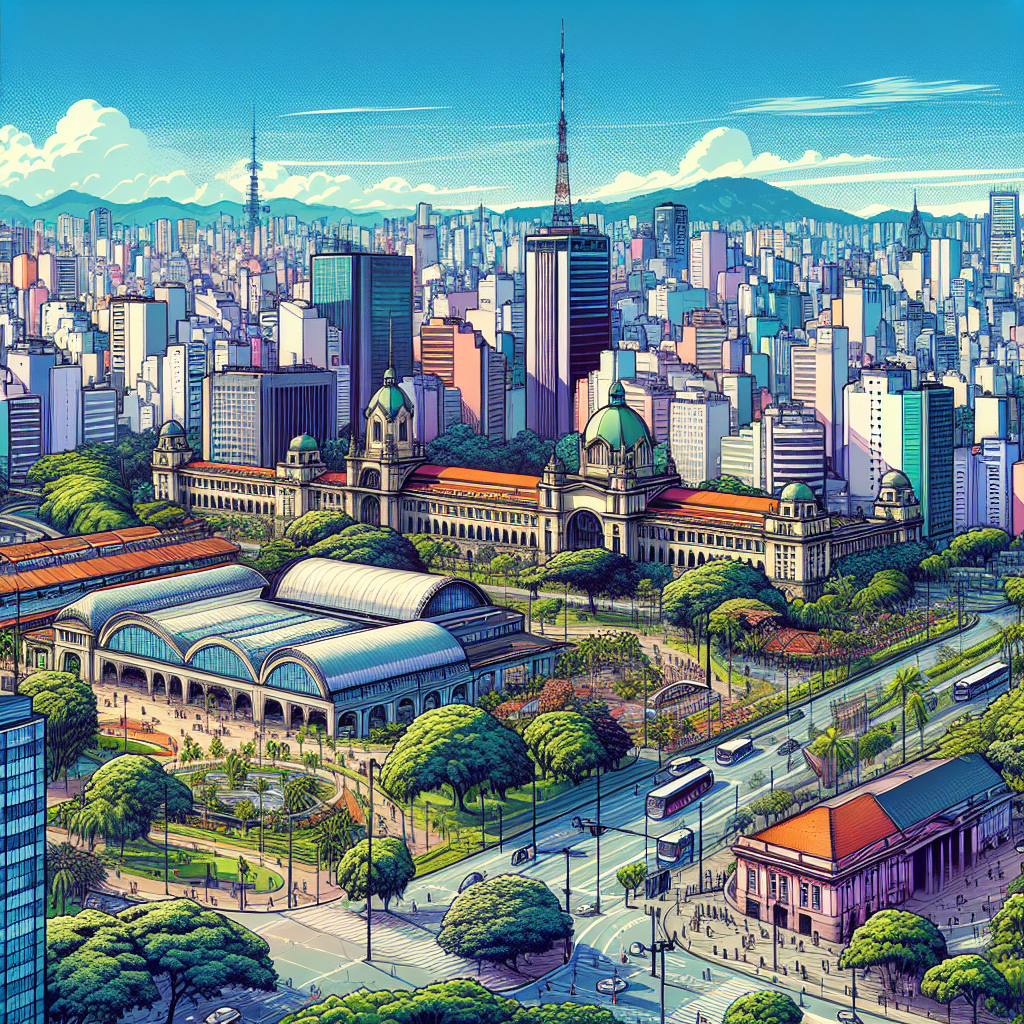

In [13]:
image = artist("São Paulo")
display(image)

<!-- ## Audio (NOTE - Audio is optional for this course - feel free to skip Audio if it causes trouble!)

And let's make a function talker that uses OpenAI's speech model to generate Audio

### Troubleshooting Audio issues

If you have any problems running this code below (like a FileNotFound error, or a warning of a missing package), you may need to install FFmpeg, a very popular audio utility.

**For PC Users**

Detailed instructions are [here](https://chatgpt.com/share/6724efee-6b0c-8012-ac5e-72e2e3885905) and summary instructions:

1. Download FFmpeg from the official website: https://ffmpeg.org/download.html

2. Extract the downloaded files to a location on your computer (e.g., `C:\ffmpeg`)

3. Add the FFmpeg bin folder to your system PATH:
- Right-click on 'This PC' or 'My Computer' and select 'Properties'
- Click on 'Advanced system settings'
- Click on 'Environment Variables'
- Under 'System variables', find and edit 'Path'
- Add a new entry with the path to your FFmpeg bin folder (e.g., `C:\ffmpeg\bin`)
- Restart your command prompt, and within Jupyter Lab do Kernel -> Restart kernel, to pick up the changes

4. Open a new command prompt and run this to make sure it's installed OK
`ffmpeg -version`

**For Mac Users**

1. Install homebrew if you don't have it already by running this in a Terminal window and following any instructions:  
`/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

2. Then install FFmpeg with `brew install ffmpeg`

3. Verify your installation with `ffmpeg -version` and if everything is good, within Jupyter Lab do Kernel -> Restart kernel to pick up the changes

Message me or email me at ed@edwarddonner.com with any problems! -->

# Agora vamos criar um narrador para o nosso projeto

In [32]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display
import os

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx", #coral
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))
    
text_tts = "Há mais coisas boas em você do que você sabe, filho do gentil Oeste." 
text_tts += "Alguma coragem e alguma sabedoria, misturadas na medida certa. Se mais de nós déssemos mais valor a comida, "
text_tts += "bebida e música do que a tesouros, o mundo seria mais alegre - Thorin Escudo de Carvalho - O Hobbit"

talker(text_tts)

# Estrutura de agente

O termo 'Agentic AI' e Agentização é um termo abrangente que se refere a uma série de técnicas, como:

1. Dividir um problema complexo em etapas menores, com vários LLMs realizando tarefas especializadas
2. A capacidade dos LLMs de usar ferramentas para dar a eles capacidades adicionais
3. O 'Ambiente do agente' que permite que os agentes colaborem
4. Um LLM pode atuar como o planejador, dividindo tarefas maiores em menores para os especialistas
5. O conceito de um agente ter autonomia/agência, além de apenas responder a um prompt - como a memória

Este simples exemplo traz o 1 e 2 e em menor extensão, 3 e 5.

In [33]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Chama o narador.
    talker(reply)
    
    return history, image

In [ ]:
# Não estamos explorando a fundo os recursos do Gradio, apenas o basico para termos um chat funcional

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
